In [1]:
import sys
sys.path.append('..')
from src.analyse_utils_keras import plot_history
from src.model_utils_keras import load_model_history
from src.data_prepare import *
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import backend as K
import cv2

/home/cugtyt/software/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
vanilla_sgd_model, vanilla_sgd_history = load_model_history('vanilla_sgd_keras')
vanilla_adam_model, vanilla_adam_history = load_model_history('vanilla_adam_keras')
resnet1_model, resnet1_history = load_model_history('resnet_keras')
resnet2_model, resnet2_history = load_model_history('resnet_keras2')
densenet1_model, densenet1_history = load_model_history('densenet_keras')
densenet2_model, densenet2_history = load_model_history('densenet_keras2')

/home/cugtyt/software/miniconda3/lib/python3.6/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [3]:
vanilla_sgd_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 63, 63, 64)        36928     
__________

# Visualizing intermediate activations

In [2]:
image_path = '../../data/Asian/AF0301_1100_00F.jpg'

img = image.load_img(image_path, target_size=(128, 128))
img_tensor = np.expand_dims(image.img_to_array(img), axis=0) / 255

print(img_tensor.shape)

(1, 128, 128, 3)


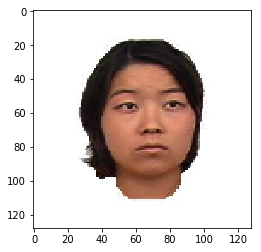

In [5]:
plt.imshow(img_tensor[0])

In [36]:
layer_outputs = [layer.output for layer in vanilla_sgd_model.layers[:10]]
activation_model = models.Model(inputs=vanilla_sgd_model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

In [37]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 128, 128, 32)


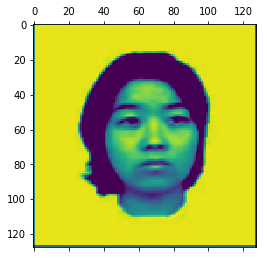

In [38]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

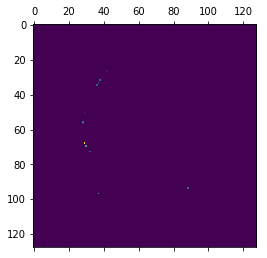

In [39]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

In [50]:
def visual_activations(model, layer_range):
    layer_outputs = [layer.output for layer in model.layers[layer_range]]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    activations = activation_model.predict(img_tensor)

    layer_names = []
    for layer in model.layers[layer_range]:
        layer_names.append(layer.name)

    images_per_row = 16

    for layer_names, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]
        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image

        scale = 1 / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_names)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

/home/cugtyt/software/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


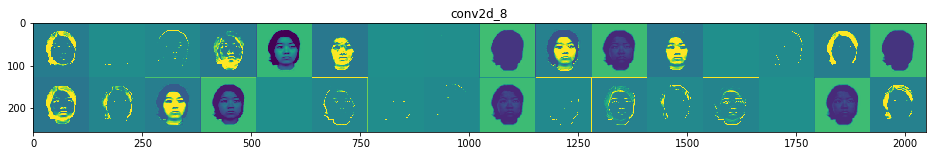

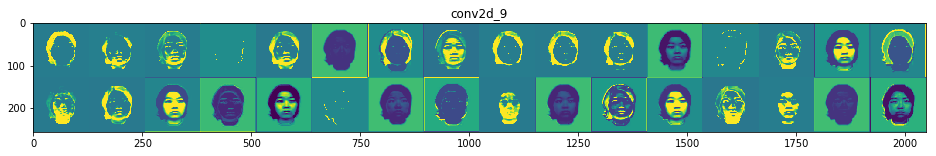

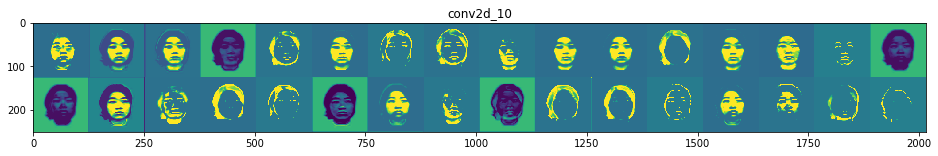

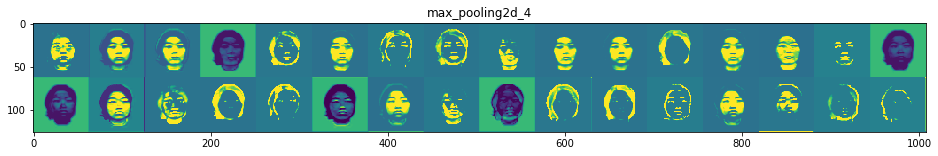

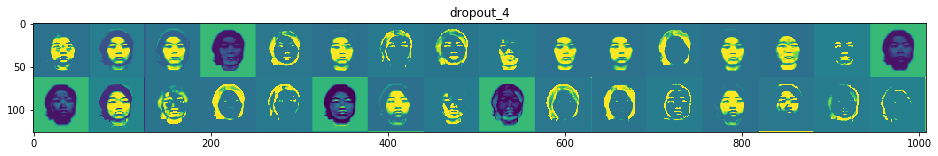

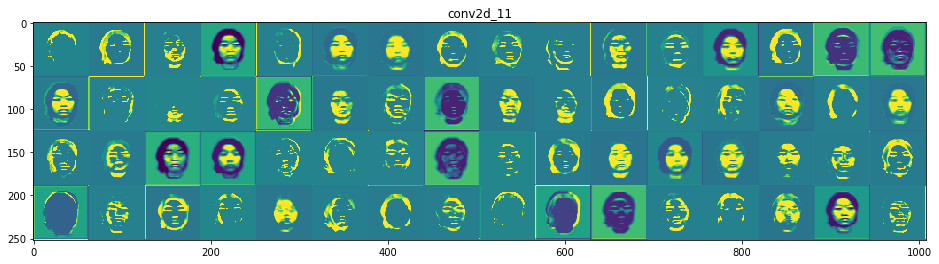

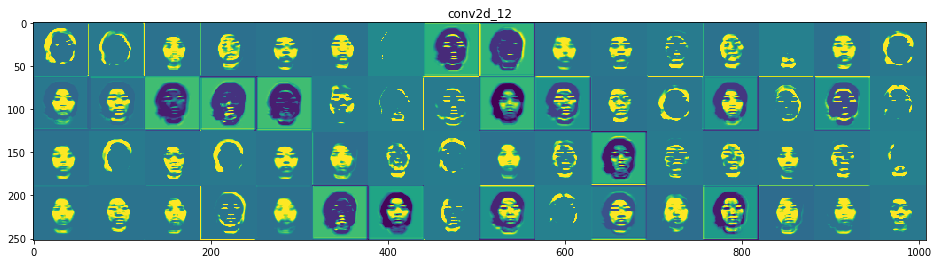

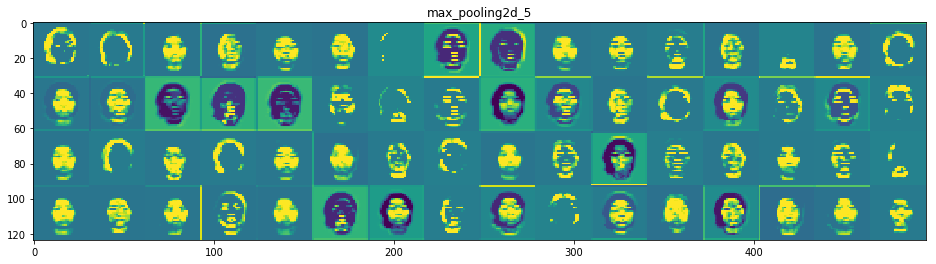

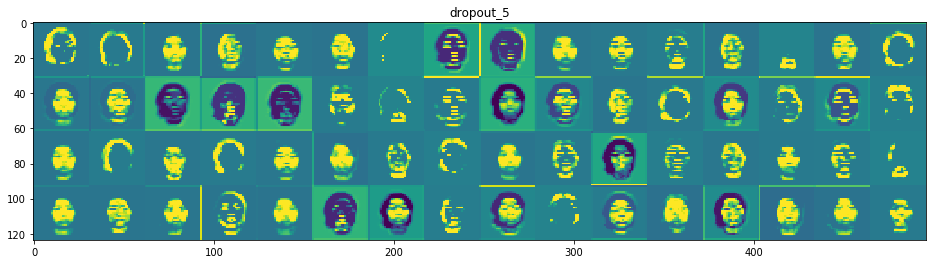

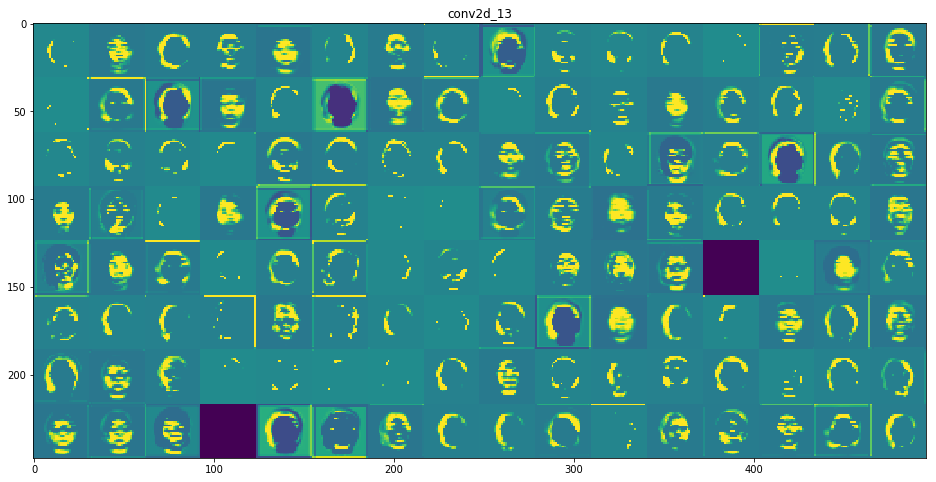

In [52]:
visual_activations(vanilla_sgd_model, slice(10))

/home/cugtyt/software/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


MemoryError: 

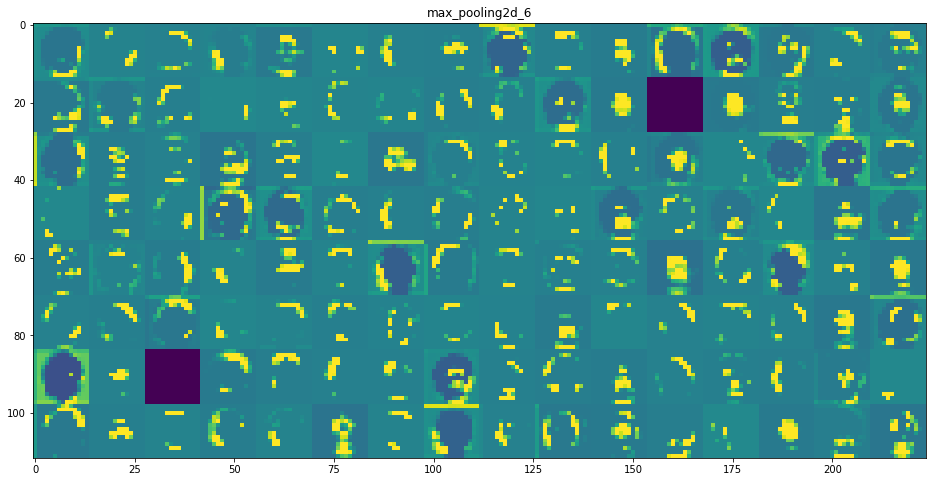

In [56]:
visual_activations(vanilla_sgd_model, slice(11, 13))

# Visualizing convnet filters

In [2]:
vanilla_adam_model, vanilla_adam_history = load_model_history('vanilla_adam_keras')

/home/cugtyt/software/miniconda3/lib/python3.6/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [3]:
def deprocess_image(x):
    x -= x.mean()
    x /= x.std() + 1e-5
    x *= 0.1
    x+= 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [20]:
def generate_pattern(model, layer_name, filter_index, size=128):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= K.sqrt(K.mean(K.square(grads))) + 1e-5
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    step = 1.
    for i in range(1000):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [21]:
plt.imshow(generate_pattern(vanilla_adam_model, 'conv2d_21', 0))

<class 'numpy.ndarray'>


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


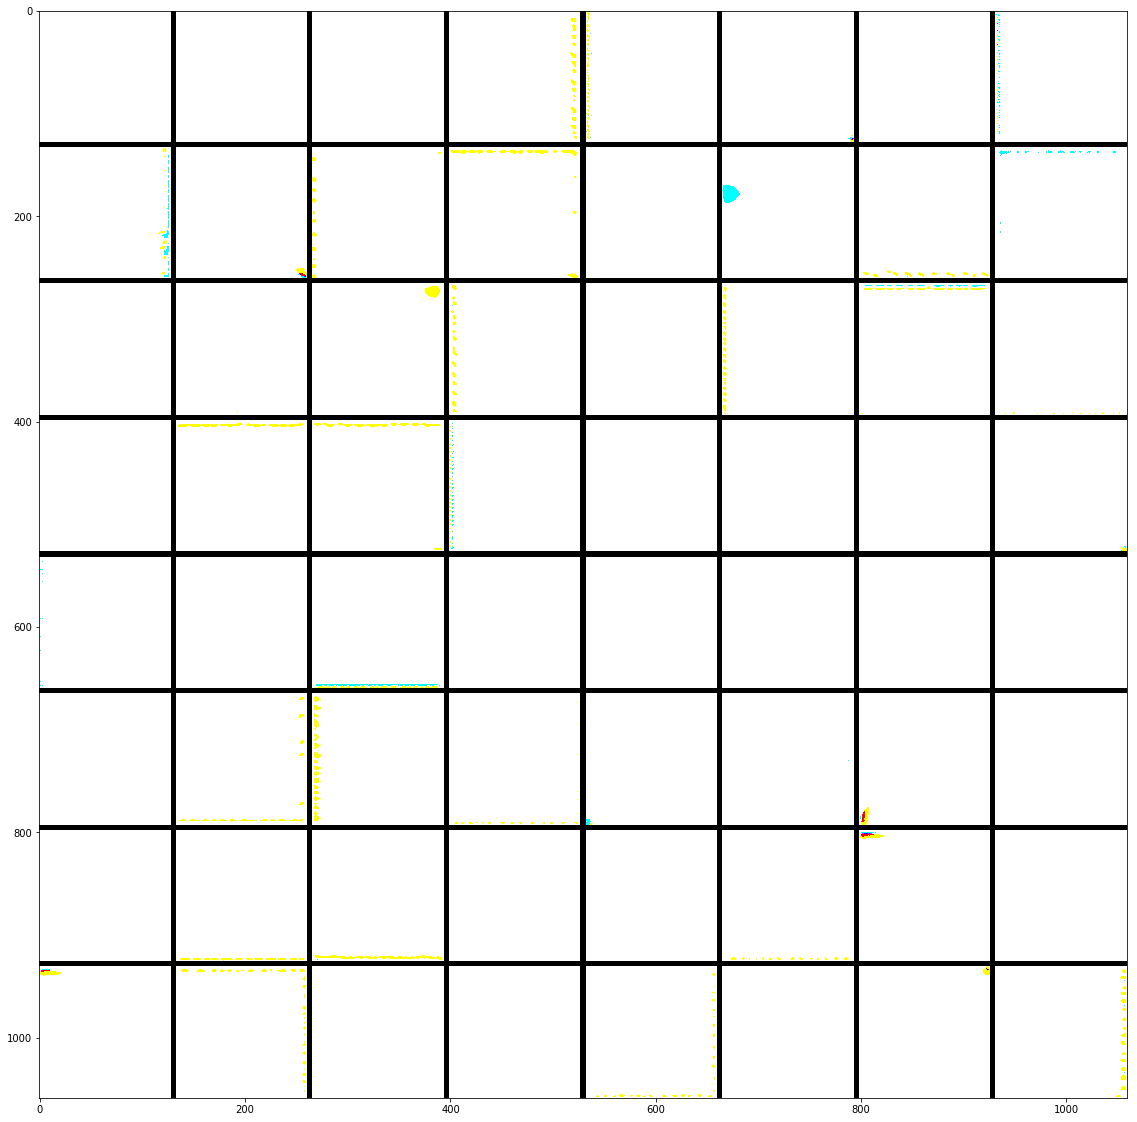

In [59]:
# layer_names = []
# for layer in vanilla_sgd_model.layers[:8]:
#     layer_names.append(layer.name)
    
layer_name = 'conv2d_11'
size = 128
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(vanilla_sgd_model, layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
        
plt.figure(figsize=(20, 20))
plt.imshow(results)

# Visualizing heatmaps of class activation

In [76]:
preds = vanilla_sgd_model.predict(img_tensor)

In [77]:
np.argmax(preds[0])

0

In [81]:
face_output = vanilla_sgd_model.output[:, 2]
last_conv_layer = vanilla_sgd_model.get_layer('conv2d_13')
grads = K.gradients(face_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([vanilla_sgd_model.input], [pooled_grads, last_conv_layer.output[0]])
pooles_grads_value, conv_layer_output_value = iterate([img_tensor])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooles_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

IndexError: index 128 is out of bounds for axis 2 with size 128

# visualize filters

In [3]:
model, history = load_model_history('densenet_keras_reduced3')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 128, 128, 16) 448         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 128, 128, 16) 64          conv2d_34[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 128, 128, 16) 0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
concatenat

In [10]:
layers = [layer for layer in model.layers]
length = [np.array(layer.get_weights()).shape for layer in layers]
print(length)

[(0,), (2,), (4, 16), (0,), (0,), (2,), (4, 16), (0,), (0,), (0,), (4, 35), (0,), (2,), (0,), (0,), (4, 16), (0,), (2,), (0,), (0,), (2,), (0,), (2,)]


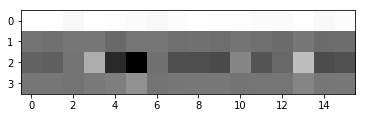

In [17]:
layer = model.layers[2]
plt.imshow(layer.get_weights(), cmap='gray')

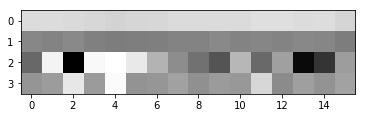

In [18]:
layer = model.layers[6]
plt.imshow(layer.get_weights(), cmap='gray')

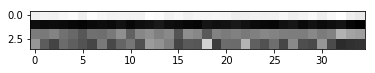

In [19]:
layer = model.layers[10]
plt.imshow(layer.get_weights(), cmap='gray')

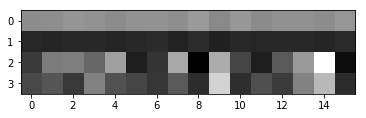

In [20]:
layer = model.layers[15]
plt.imshow(layer.get_weights(), cmap='gray')

In [21]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

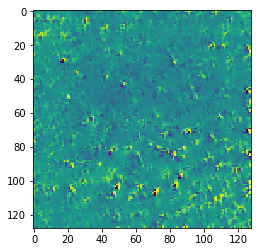

In [26]:
layer_idx = utils.find_layer_idx(model, 'dense_20')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])

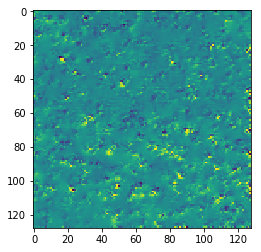

In [27]:
plt.imshow(img[..., 1])

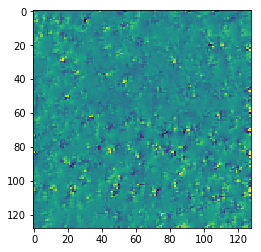

In [28]:
plt.imshow(img[..., 2])

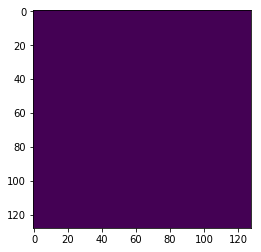

In [29]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0, 1))
plt.imshow(img[..., 0])

Iteration: 1, named_losses: <zip object at 0x7fdc9049c448>, overall loss: 26.029949188232422
Iteration: 2, named_losses: <zip object at 0x7fdc9048c7c8>, overall loss: -1286.33935546875
Iteration: 3, named_losses: <zip object at 0x7fdc904fde48>, overall loss: -3670.79541015625
Iteration: 4, named_losses: <zip object at 0x7fdc90428208>, overall loss: -6854.68701171875
Iteration: 5, named_losses: <zip object at 0x7fdc904b0088>, overall loss: -10273.6943359375
Iteration: 6, named_losses: <zip object at 0x7fdc90419588>, overall loss: -13710.275390625
Iteration: 7, named_losses: <zip object at 0x7fdc90428208>, overall loss: -16601.033203125
Iteration: 8, named_losses: <zip object at 0x7fdc90479e08>, overall loss: -19379.05078125
Iteration: 9, named_losses: <zip object at 0x7fdc904eff08>, overall loss: -21923.236328125
Iteration: 10, named_losses: <zip object at 0x7fdc904efa88>, overall loss: -24458.46484375
Iteration: 11, named_losses: <zip object at 0x7fdc904ef6c8>, overall loss: -26715.148

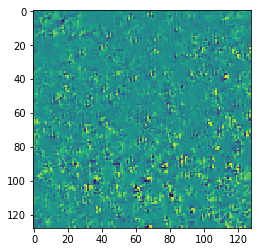

In [30]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), verbose=True)
plt.imshow(img[..., 0])

Iteration: 1, named_losses: <zip object at 0x7fdc902d4208>, overall loss: 27.17902374267578
Iteration: 2, named_losses: <zip object at 0x7fdc90369e88>, overall loss: -2107.1279296875
Iteration: 3, named_losses: <zip object at 0x7fdc90369b88>, overall loss: -5188.56201171875
Iteration: 4, named_losses: <zip object at 0x7fdc9035c208>, overall loss: -8908.03125
Iteration: 5, named_losses: <zip object at 0x7fdc9035c148>, overall loss: -12597.4677734375
Iteration: 6, named_losses: <zip object at 0x7fdc9035cc08>, overall loss: -16213.7939453125
Iteration: 7, named_losses: <zip object at 0x7fdc9035c208>, overall loss: -19462.814453125
Iteration: 8, named_losses: <zip object at 0x7fdc9035c608>, overall loss: -23077.19921875
Iteration: 9, named_losses: <zip object at 0x7fdc9035ce48>, overall loss: -26050.953125
Iteration: 10, named_losses: <zip object at 0x7fdc90353088>, overall loss: -28762.0078125
Iteration: 11, named_losses: <zip object at 0x7fdc90353c08>, overall loss: -31521.341796875
Iter

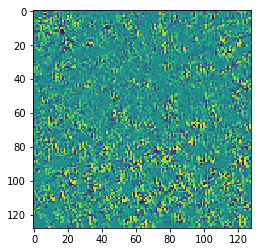

In [31]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                           tv_weight=0., lp_norm_weight=0., verbose=True)
plt.imshow(img[..., 0])

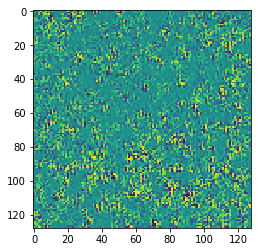

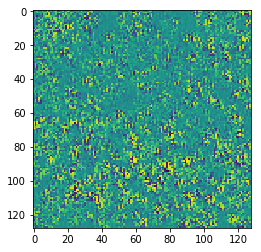

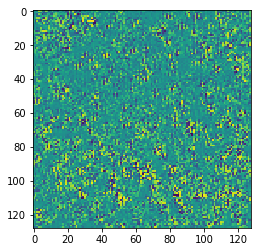

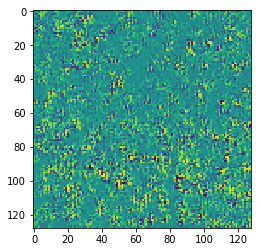

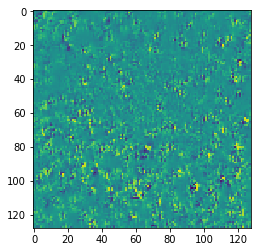

In [32]:
for tv_weight in [1e-3, 1e-2, 1e-1, 1, 10]:
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                               tv_weight=tv_weight, lp_norm_weight=0.)
    plt.figure()
    plt.imshow(img[..., 0])

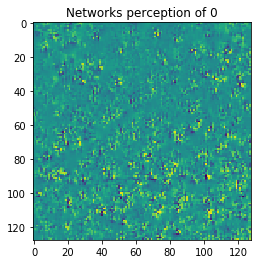

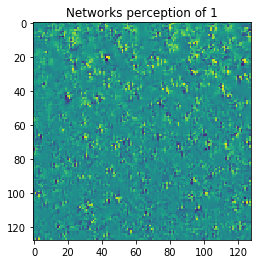

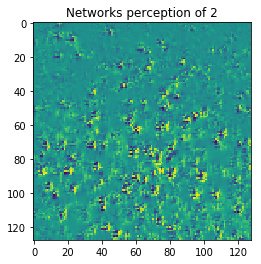

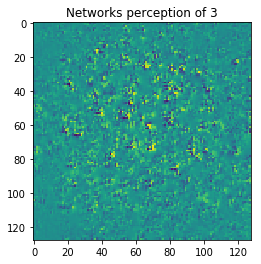

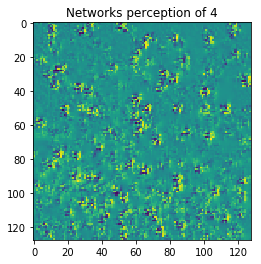

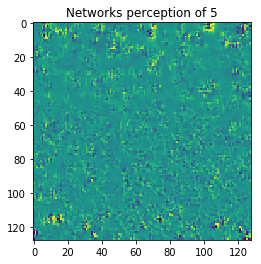

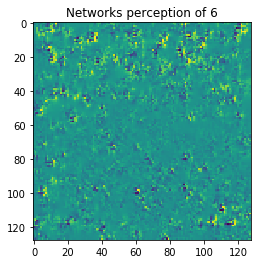

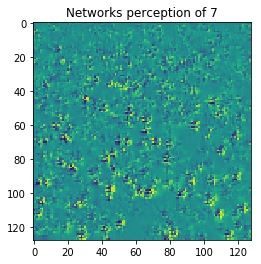

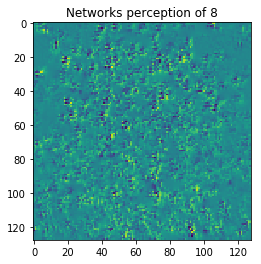

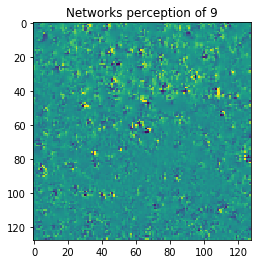

In [33]:
for output_idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])

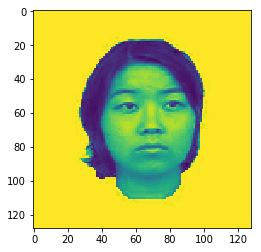

In [40]:
image_path = '../../data/Asian/AF0301_1100_00F.jpg'

img = image.load_img(image_path, target_size=(128, 128))
img_tensor = np.expand_dims(image.img_to_array(img), axis=0) / 255

class_idx = 0
plt.imshow(img_tensor[0][..., 0])

In [37]:
from vis.visualization import visualize_saliency

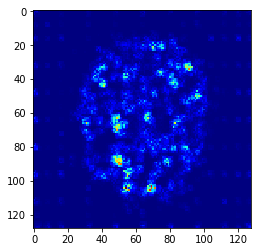

In [41]:
grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=img_tensor[0])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

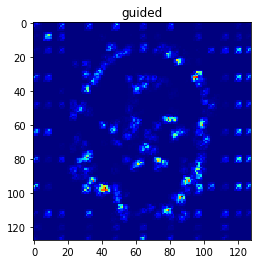

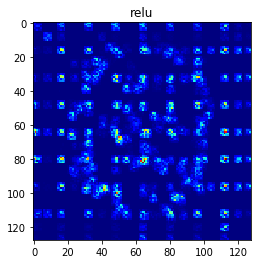

In [42]:
for modifier in ['guided', 'relu']:
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=img_tensor[0], backprop_modifier=modifier)
    plt.figure()
    plt.title(modifier)
    plt.imshow(grads, cmap='jet')

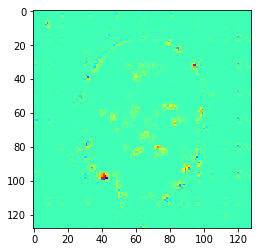

In [44]:
grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=img_tensor[0], 
                           backprop_modifier='guided', grad_modifier='negate')
plt.imshow(grads, cmap='jet')

In [45]:
# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                   seed_input=x_test[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

NameError: name 'y_test' is not defined

In [ ]:
def iter_occlusion(image, size=8):
   # taken from https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, (
      (occlusion_padding, occlusion_padding), 
      (occlusion_padding, occlusion_padding), 
      (0, 0)), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
            x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center
            yield x - occlusion_padding, y - occlusion_padding, \
            tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]i = 23 # for exampledata = val_x[i]correct_class = np.argmax(val_y[i])

# input tensor for model.predictinp = data.reshape(1, 28, 28, 1)# image data for matplotlib's imshowimg = data.reshape(28, 28)
# occlusionimg_size = img.shape[0]

occlusion_size = 4print('occluding...')heatmap = np.zeros((img_size, img_size), np.float32)class_pixels = np.zeros((img_size, img_size), np.int16)
from collections import defaultdict
counters = defaultdict(int)for n, (x, y, img_float) in enumerate(iter_occlusion(data, size=occlusion_size)):

   X = img_float.reshape(1, 28, 28, 1)
   out = model.predict(X)
   #print('#{}: {} @ {} (correct class: {})'.format(n, np.argmax(out), np.amax(out), out[0][correct_class]))
   #print('x {} - {} | y {} - {}'.format(x, x + occlusion_size, y, y + occlusion_size))

   heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
   class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
   counters[np.argmax(out)] += 1

In [34]:
import sys
sys.path.append('..')
%matplotlib inline
from vis.visualization import visualize_activation, visualize_saliency, overlay
from vis.utils import utils
from keras import activations
from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np
from src.data_prepare import *
from src.model_utils_keras import load_model_history
from vis.visualization import visualize_cam
from keras.preprocessing import image
from keras import models
import cv2
import matplotlib.cm as cm
from vis.visualization import visualize_cam

# Load model

In [30]:
model, history = load_model_history('densenet_keras_reduced3')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 128, 128, 16) 448         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 128, 128, 16) 64          conv2d_34[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 128, 128, 16) 0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
concatenat

# Dense layer visualizations *by keras-vis*

In [31]:
layer_idx = utils.find_layer_idx(model, 'dense_20')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)

In [8]:
img.shape

(128, 128, 3)

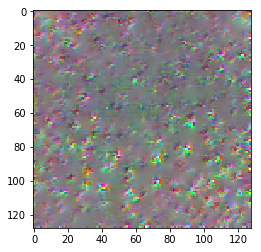

In [9]:
plt.imshow(img)

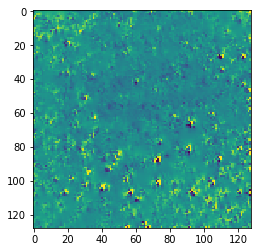

In [10]:
plt.imshow(img[..., 0])

## Specifying input_range

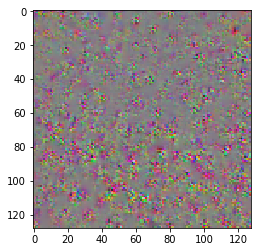

In [11]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.))
plt.imshow(img)

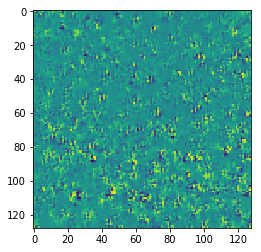

In [12]:
plt.imshow(img[..., 0])

## Tuning regularization weights

Iteration: 1, named_losses: <zip object at 0x7fcc084384c8>, overall loss: 25.680444717407227
Iteration: 2, named_losses: <zip object at 0x7fcc08428048>, overall loss: -1160.131591796875
Iteration: 3, named_losses: <zip object at 0x7fcc083b6608>, overall loss: -3648.68408203125
Iteration: 4, named_losses: <zip object at 0x7fcc08417088>, overall loss: -7137.72216796875
Iteration: 5, named_losses: <zip object at 0x7fcc08428848>, overall loss: -10558.6328125
Iteration: 6, named_losses: <zip object at 0x7fcc084172c8>, overall loss: -13858.3330078125
Iteration: 7, named_losses: <zip object at 0x7fcc08394e88>, overall loss: -16830.1640625
Iteration: 8, named_losses: <zip object at 0x7fcc08417088>, overall loss: -19760.064453125
Iteration: 9, named_losses: <zip object at 0x7fcc084172c8>, overall loss: -22101.05078125
Iteration: 10, named_losses: <zip object at 0x7fcc08428848>, overall loss: -24499.04296875
Iteration: 11, named_losses: <zip object at 0x7fcc08409748>, overall loss: -26927.009765

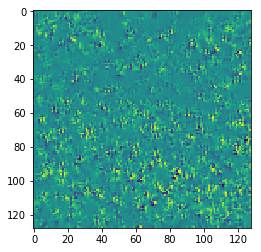

In [13]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), verbose=True)
plt.imshow(img[..., 0])

Iteration: 1, named_losses: <zip object at 0x7fcc080faa08>, overall loss: 25.792516708374023
Iteration: 2, named_losses: <zip object at 0x7fcc08110588>, overall loss: -2030.6324462890625
Iteration: 3, named_losses: <zip object at 0x7fcc0817b308>, overall loss: -4817.88427734375
Iteration: 4, named_losses: <zip object at 0x7fcc0817b548>, overall loss: -8316.0263671875
Iteration: 5, named_losses: <zip object at 0x7fcc0816a808>, overall loss: -12467.8466796875
Iteration: 6, named_losses: <zip object at 0x7fcc0817b548>, overall loss: -15996.0712890625
Iteration: 7, named_losses: <zip object at 0x7fcc0816a388>, overall loss: -19501.0859375
Iteration: 8, named_losses: <zip object at 0x7fcc0816a308>, overall loss: -22766.787109375
Iteration: 9, named_losses: <zip object at 0x7fcc0816a588>, overall loss: -25731.41015625
Iteration: 10, named_losses: <zip object at 0x7fcc0816a8c8>, overall loss: -28566.359375
Iteration: 11, named_losses: <zip object at 0x7fcc0816acc8>, overall loss: -31336.09570

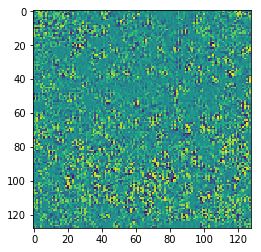

In [14]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                           tv_weight=0., lp_norm_weight=0., verbose=True)
plt.imshow(img[..., 0])

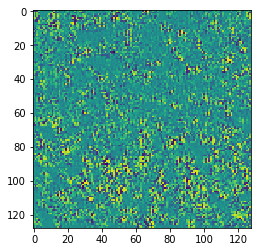

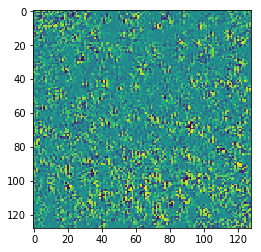

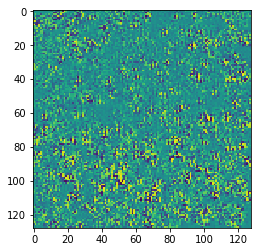

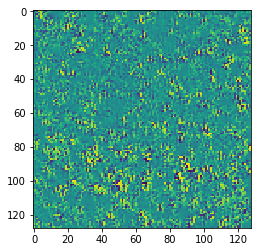

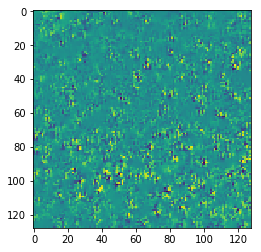

In [15]:
for tv_weight in [1e-3, 1e-2, 1e-1, 1, 10]:
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                               tv_weight=tv_weight, lp_norm_weight=0.)
    plt.figure()
    plt.imshow(img[..., 0])

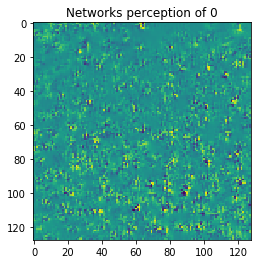

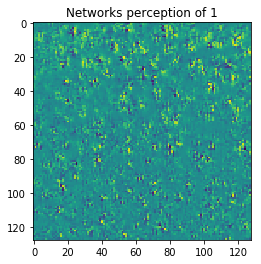

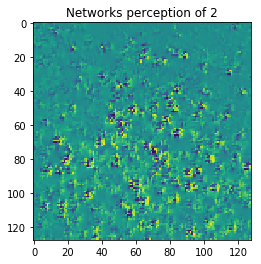

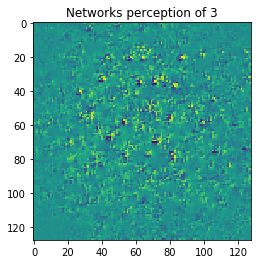

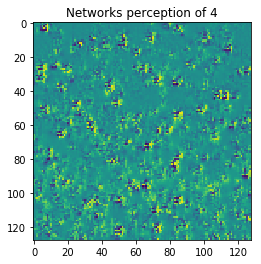

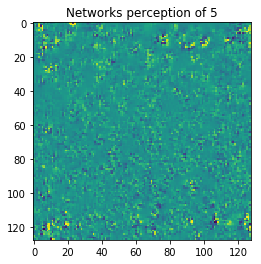

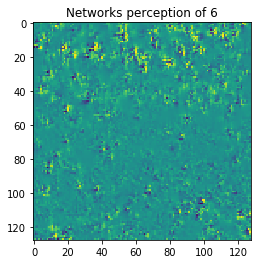

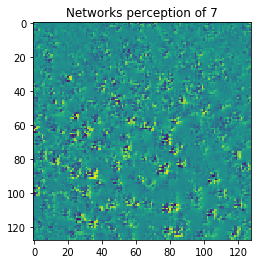

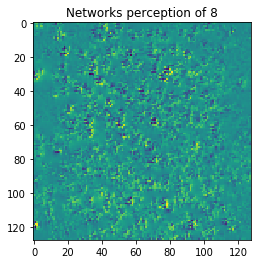

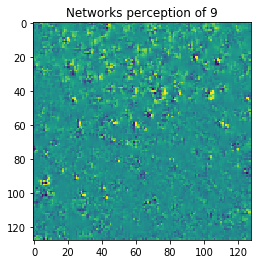

In [16]:
for output_idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])

## Visualizations without swapping softmax

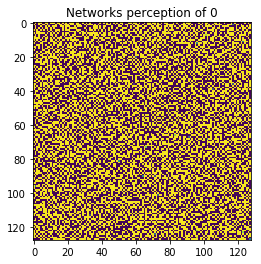

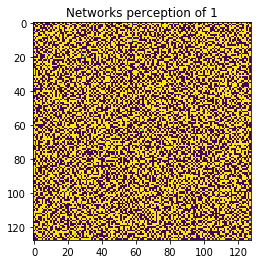

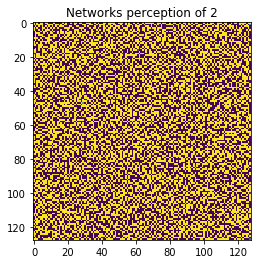

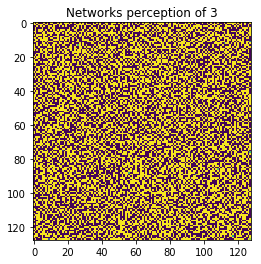

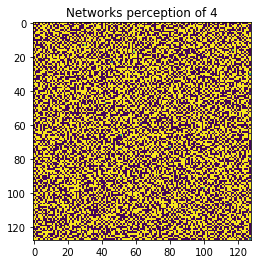

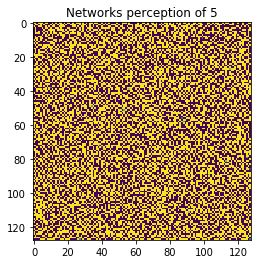

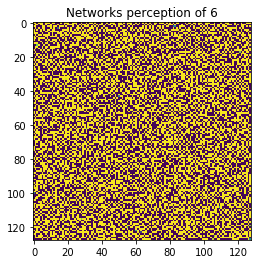

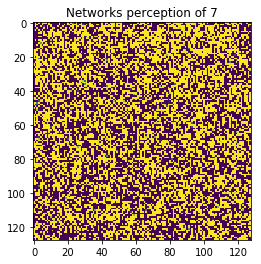

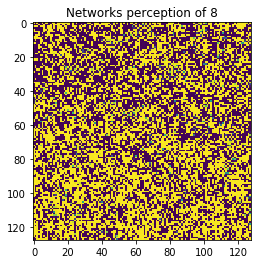

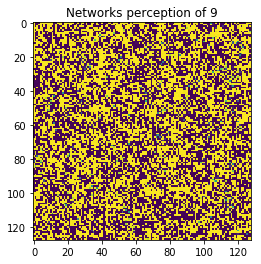

In [17]:
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

for output_idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])

# Attention (Saliency and grad-CAM) *by keras-vis*

In [2]:
train_data, test_data, train_label, test_label = avg_float_asian()

In [3]:
test_label

array([51, 13, 40, 15, 50, 34,  9, 34, 11, 21, 17, 49,  2,  1,  9, 14, 29,
       18,  9, 29, 21, 14, 39, 20, 52,  4, 33,  8, 37, 22,  4, 36, 28,  4,
       44, 38,  2, 33, 41, 50, 16, 49, 46,  0, 21, 52, 12,  1, 28, 47, 10,
       28,  3,  2, 11, 20,  3, 52, 29, 20, 11,  8, 20, 10, 43, 38, 44, 23,
       18, 46, 49, 28, 34,  1,  3, 52, 27, 22, 16, 14,  9, 14, 15, 37, 40,
       28, 51, 23, 35, 51, 16, 17, 16,  8, 29, 10,  2, 49, 19, 32, 41, 46,
        7, 28, 23,  2, 30, 12, 16,  3, 10, 16,  7, 49,  9, 35, 30, 42, 21,
       28, 14, 18,  8, 36, 45,  7, 34, 20, 32, 14, 52, 12, 45, 40, 34,  1,
       29, 38,  1, 12, 40,  8,  7,  2,  9, 17, 43, 14, 36, 45, 30, 44, 47,
        1,  4,  5, 48, 15, 46, 43, 14, 52,  6, 15,  4, 40, 41, 27, 50, 49,
       18, 24, 15, 11, 16, 32, 15,  6, 19, 27, 25, 35, 12, 20,  6,  7, 34,
       13, 27,  2, 20, 32, 47,  2, 38, 47,  4, 21, 26, 14, 46, 18, 52,  9,
       24, 51, 51, 35, 27, 14, 25, 21, 42, 20, 33, 39, 30, 36, 29, 19, 33,
       35,  6, 51, 45, 34

In [4]:
test_label.shape

(257,)

In [5]:
test_data.shape

(257, 128, 128, 3)

## Saliency

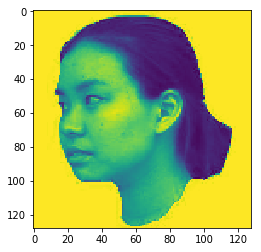

In [6]:
class_idx = 0
indices = np.where(test_label == 2)[0]

# pick some random input from here.
idx = indices[0]

plt.imshow(test_data[idx][..., 0])

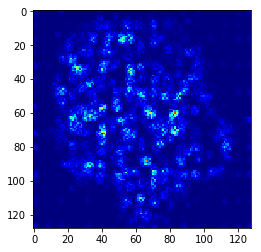

In [11]:
layer_idx = utils.find_layer_idx(model, 'dense_20')

model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=test_data[idx])
plt.imshow(grads, cmap='jet')

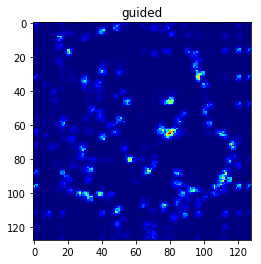

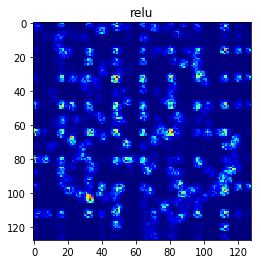

In [13]:
for modifier in ['guided', 'relu']:
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=test_data[idx], backprop_modifier=modifier)
    plt.figure()
    plt.title(modifier)
    plt.imshow(grads, cmap='jet')

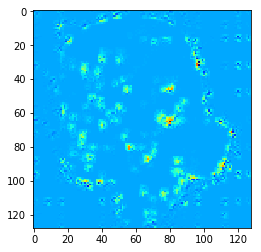

In [14]:
grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=test_data[idx], 
                           backprop_modifier='guided', grad_modifier='negate')
plt.imshow(grads, cmap='jet')

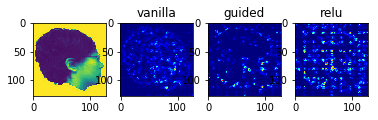

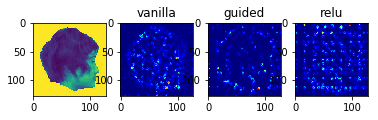

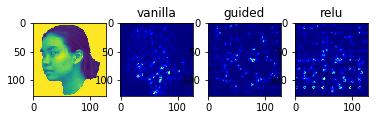

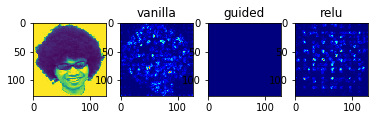

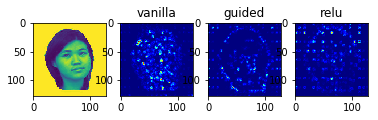

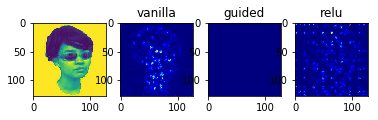

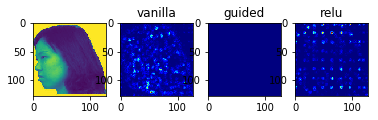

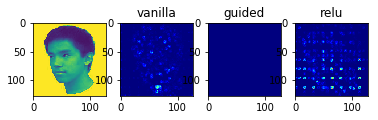

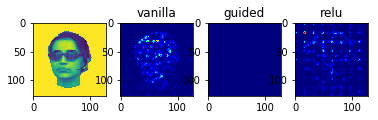

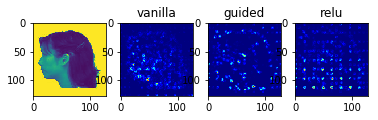

In [16]:
# This corresponds to the Dense linear layer.
for class_idx in range(10):    
    indices = np.where(test_label == class_idx)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(test_data[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                   seed_input=test_data[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

## grad-CAM - vanilla, guided, rectified

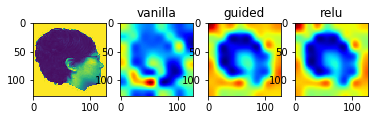

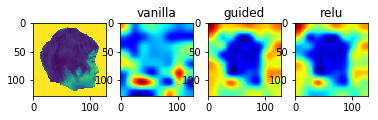

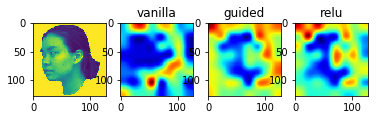

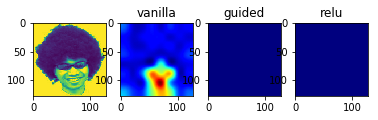

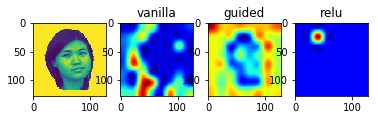

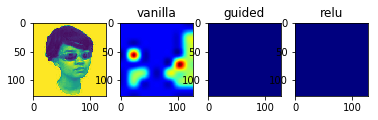

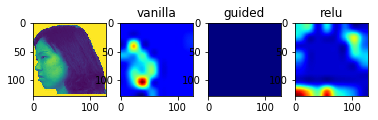

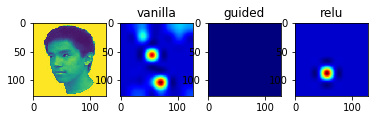

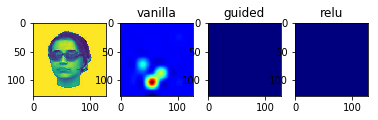

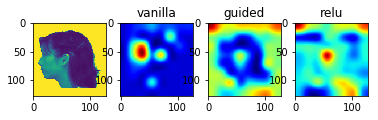

In [18]:
# This corresponds to the Dense linear layer.
for class_idx in range(10):    
    indices = np.where(test_label == class_idx)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(test_data[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                              seed_input=test_data[idx], backprop_modifier=modifier)        
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

## Visualization without swapping softmax

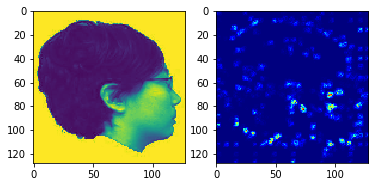

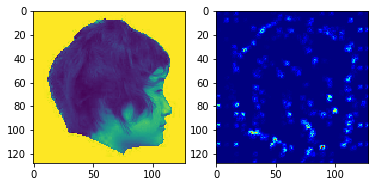

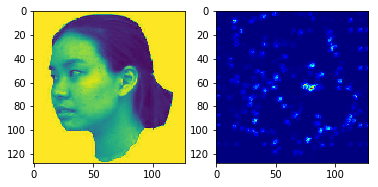

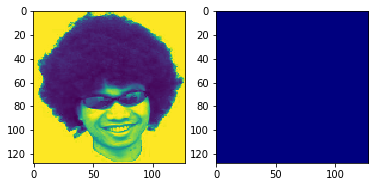

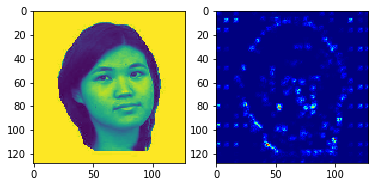

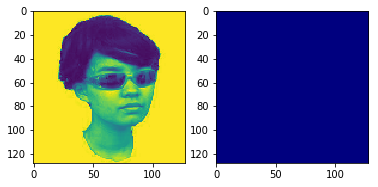

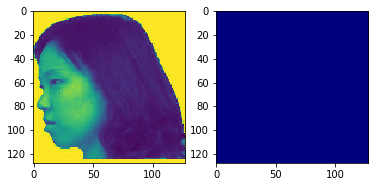

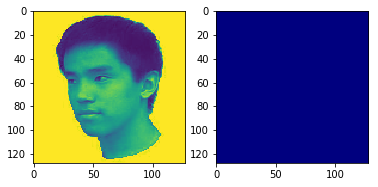

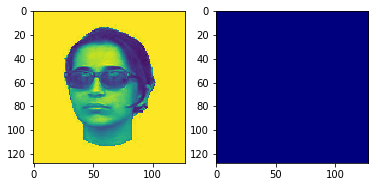

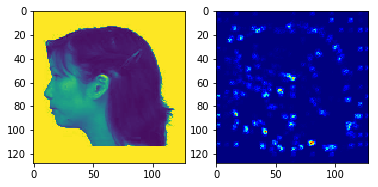

In [19]:
# Swap linear back with softmax
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

for class_idx in range(10):    
    indices = np.where(test_label == class_idx)[0]
    idx = indices[0]
    
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                               seed_input=test_data[idx], backprop_modifier='guided')

    f, ax = plt.subplots(1, 2)
    ax[0].imshow(test_data[idx][..., 0])
    ax[1].imshow(grads, cmap='jet')

# Visualizing what convnets learn *by dl-py*

(1, 128, 128, 3)


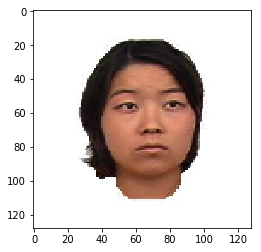

In [3]:
image_path = '../../data/Asian/AF0301_1100_00F.jpg'

img = image.load_img(image_path, target_size=(128, 128))
img_tensor = np.expand_dims(image.img_to_array(img), axis=0) / 255

print(img_tensor.shape)
plt.imshow(img_tensor[0])

In [21]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[1:]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
print(len(activations))
first_layer_activation = activations[1]
print(first_layer_activation.shape)

22
(1, 128, 128, 16)


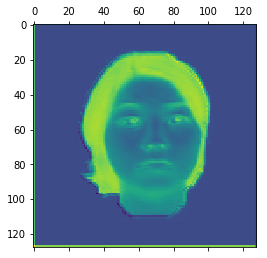

In [14]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

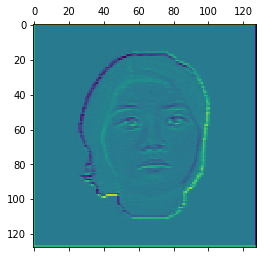

In [15]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

['conv2d_34', 'batch_normalization_34', 'activation_34', 'concatenate_19', 'conv2d_35', 'batch_normalization_35', 'activation_35', 'concatenate_20', 'max_pooling2d_34', 'batch_normalization_36', 'activation_36', 'conv2d_36', 'max_pooling2d_35', 'max_pooling2d_36', 'batch_normalization_37', 'activation_37', 'conv2d_37', 'max_pooling2d_37', 'flatten_10', 'dense_19', 'dropout_10', 'dense_20']
conv2d_34
128 2048
16.0 1.0
batch_normalization_34
128 2048
16.0 1.0
activation_34
128 2048
16.0 1.0
concatenate_19
128 2048
16.0 1.0
conv2d_35
128 2048
16.0 1.0
batch_normalization_35
128 2048
16.0 1.0
activation_35
128 2048
16.0 1.0
concatenate_20
256 2048
16.0 2.0
max_pooling2d_34
128 1024
16.0 2.0
batch_normalization_36
128 1024
16.0 2.0
activation_36
128 1024
16.0 2.0
conv2d_36
64 1024
16.0 1.0
max_pooling2d_35
32 512
16.0 1.0
max_pooling2d_36
16 256
16.0 1.0
batch_normalization_37
16 256
16.0 1.0
activation_37
16 256
16.0 1.0
conv2d_37
16 256
16.0 1.0
max_pooling2d_37
8 128
16.0 1.0
flatten_10


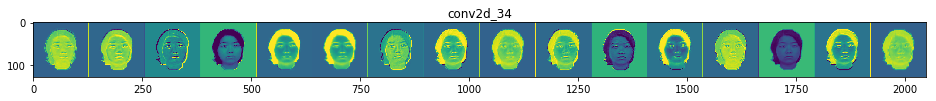

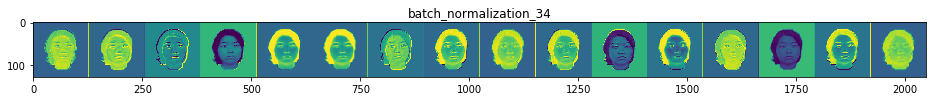

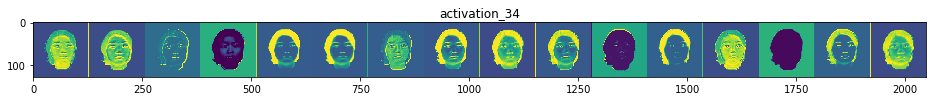

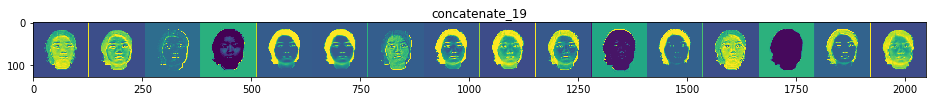

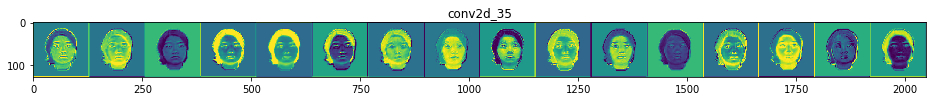

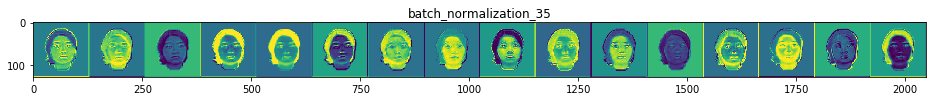

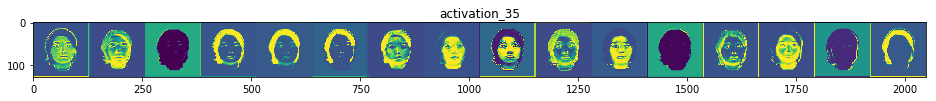

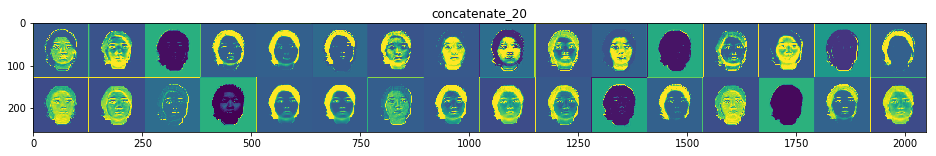

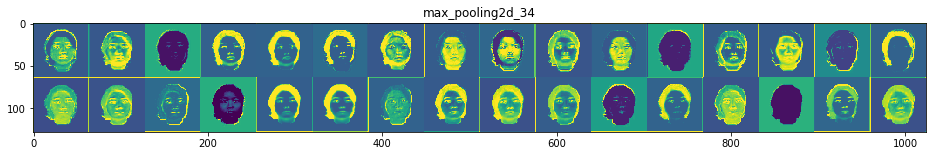

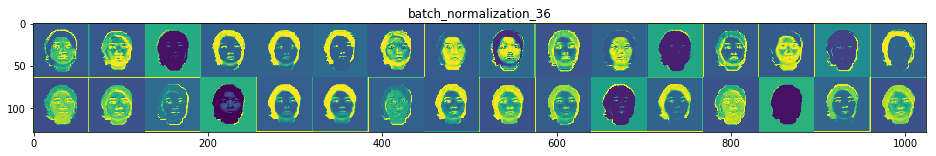

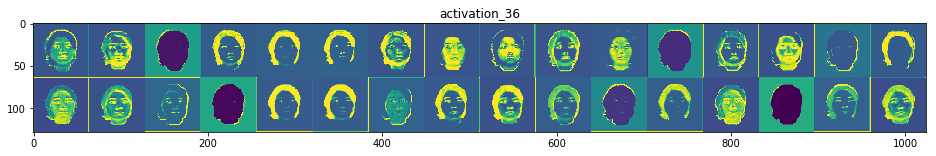

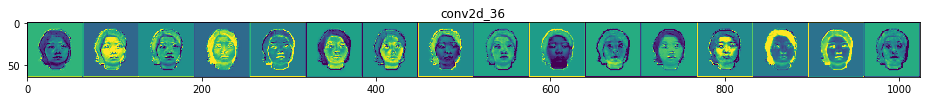

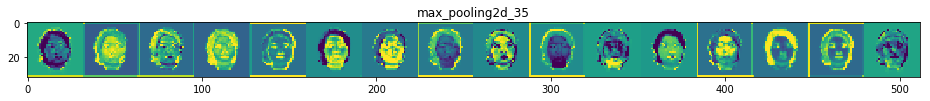

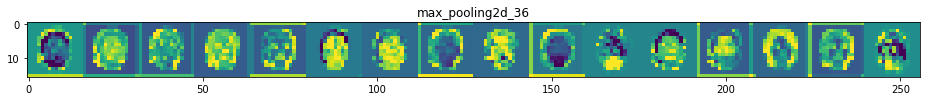

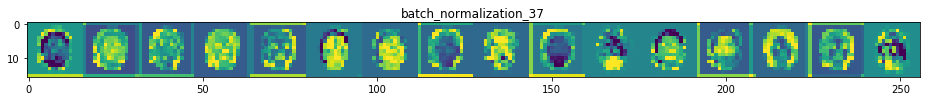

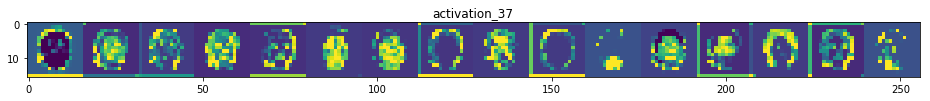

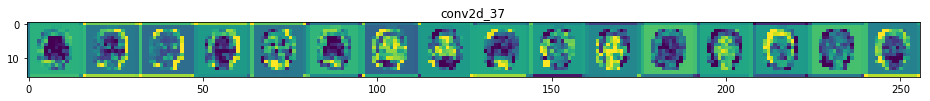

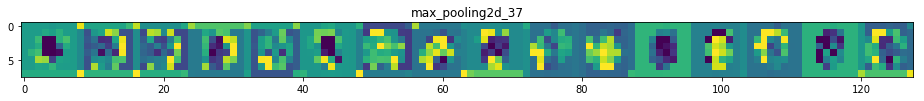

In [25]:
layer_names = []
for layer in model.layers[1:]:
    layer_names.append(layer.name)
    
    
images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('flatten'):
        break
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]
    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    print(size * n_cols, images_per_row * size)
    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                row * size : (row + 1) * size] = channel_image
    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    print(scale * display_grid.shape[1], scale * display_grid.shape[0])
    plt.title(layer_name)
#     plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Visualizing heatmaps of class activation

In [28]:
model, history = load_model_history('vanilla_adam_keras')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 63, 63, 64)        36928     
__________

/home/cugtyt/software/miniconda3/lib/python3.6/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [9]:
preds = model.predict(img_tensor)
print(np.argmax(preds))

0


In [10]:
img_tensor.shape

(1, 128, 128, 3)

In [11]:
model.output

<tf.Tensor 'dense_6/Softmax:0' shape=(?, 10) dtype=float32>

(?, 29, 29, 128)


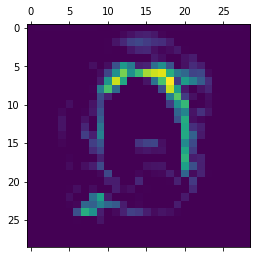

In [12]:
img_output = model.output[:, 0]
last_conv_layer = model.get_layer('conv2d_21')
grads = K.gradients(img_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])
for i in range(grads.shape[3]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [13]:
heatmap.shape

(29, 29)

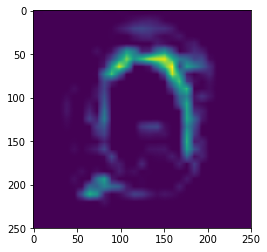

In [14]:
# We use cv2 to load the original image
img = cv2.imread(image_path)
# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
plt.imshow(heatmap)

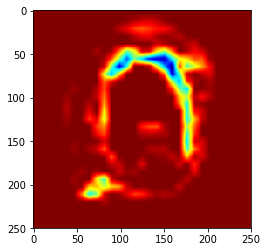

In [15]:
# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
plt.imshow(heatmap)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


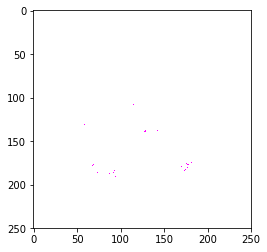

In [18]:
# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./visualizing_imgs/superimposed.jpg', superimposed_img)

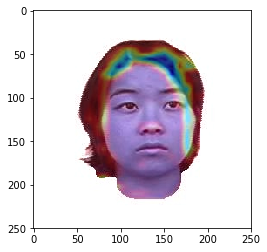

In [21]:
result = cv2.imread('./visualizing_imgs/superimposed.jpg')
plt.imshow(result)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 128, 128, 16) 448         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 128, 128, 16) 64          conv2d_34[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 128, 128, 16) 0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
concatenat

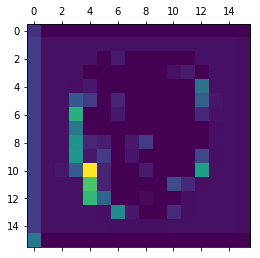

In [25]:
model, history = load_model_history('densenet_keras_reduced3')
model.summary()
image_path = '../../data/Asian/AF0301_1100_30L.jpg'

img = image.load_img(image_path, target_size=(128, 128))
img_tensor = np.expand_dims(image.img_to_array(img), axis=0) / 255

img_output = model.output[:, 0]
last_conv_layer = model.get_layer('conv2d_37')
grads = K.gradients(img_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])
for i in range(grads.shape[3]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

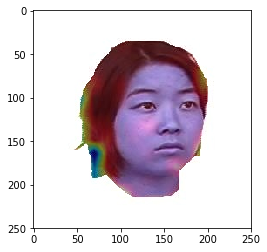

In [26]:
# We use cv2 to load the original image
img = cv2.imread(image_path)
# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./visualizing_imgs/superimposed2.jpg', superimposed_img)
result = cv2.imread('./visualizing_imgs/superimposed2.jpg')
plt.imshow(result)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 128, 128, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 128, 128, 32) 0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
concatenat

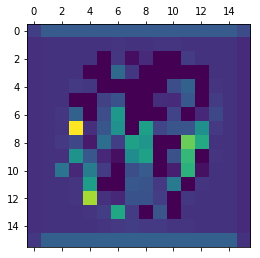

In [3]:
model, history = load_model_history('densenet_keras_reduced2')
model.summary()
image_path = '../../data/Asian/AF0301_1100_30L.jpg'

img = image.load_img(image_path, target_size=(128, 128))
img_tensor = np.expand_dims(image.img_to_array(img), axis=0) / 255

img_output = model.output[:, 0]
last_conv_layer = model.get_layer('conv2d_23')
grads = K.gradients(img_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])
for i in range(grads.shape[3]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

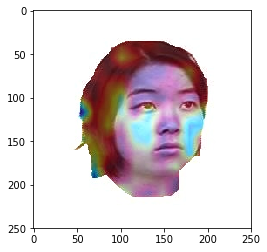

In [4]:
# We use cv2 to load the original image
img = cv2.imread(image_path)
# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./visualizing_imgs/superimposed3.jpg', superimposed_img)
result = cv2.imread('./visualizing_imgs/superimposed3.jpg')
plt.imshow(result)

/home/cugtyt/software/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<Figure size 432x288 with 0 Axes>

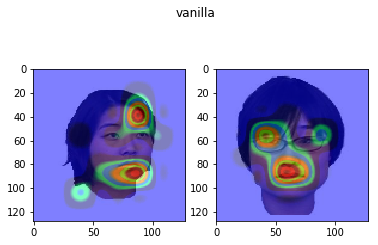

<Figure size 432x288 with 0 Axes>

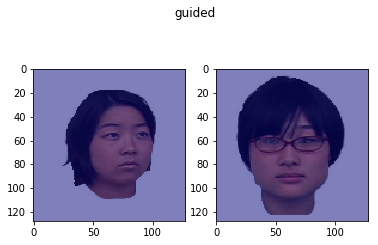

<Figure size 432x288 with 0 Axes>

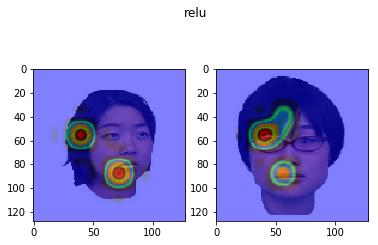

In [47]:
img1 = utils.load_img('../../data/Asian/AF0301_1100_30L.jpg', target_size=(128, 128))
img2 = utils.load_img('../../data/Asian/AF0302_2211_00F.jpg', target_size=(128, 128))

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_cam(model, layer_idx, filter_indices=0, 
                              seed_input=img, backprop_modifier=modifier)     
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., 0] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))

# Activation Maximization *by keras-vis*

In [ ]:
model, history = load_model_history('densenet_keras_reduced3')

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_20')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)
img = visualize_activation(model, layer_idx, filter_indices=0)
plt.imshow(img)